In [127]:
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
import toolz as fp
#import nltk
import warnings
# configuration
%matplotlib inline
sns.set()
%config InlineBackend.figure_format = 'svg' 
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
nltk.download('rslp')
nltk.download('stopwords');
from statsmodels.distributions.empirical_distribution import ECDF

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\lucas.oliveira\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas.oliveira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1.  Reading data

data used in this project was obtained from [minerando dados](https://github.com/minerandodados/mdrepo)

In [135]:
dataset = pd.read_csv("./base_tweets.csv", encoding='utf-8')
dataset.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## simplified binary classification model where tweets with "negative" sentiment will be assigned value 0 and positive value 1. Neutral tweets can fall into any of the categories with probability .5.

In [129]:
np.random.seed(42)

#dataset = pd.DataFrame(...)  # Assuming you have a DataFrame called 'dataset'

df = dataset.rename(columns={
    "Created At": "publication_date",
    "Text": "tweet",
    "Retweet Count": "num_retweets",
    "Username": "username",
    "Classificacao": "sentiment"
}).loc[:, ["publication_date", "tweet", "num_retweets", "username", "sentiment"]]

df["publication_date"] = pd.to_datetime(df["publication_date"], infer_datetime_format=True)

sentiment_mapping = {
    "Negativo": 0,
    "Neutro": np.random.choice([0, 1]),
    "Positivo": 1
}

df["sentiment"] = df["sentiment"].replace(sentiment_mapping)

df.head()

,publication_date,tweet,num_retweets,username,sentiment
0,2017-01-08 01:22:05+00:00,���⛪ @ Catedral de Santo Antônio - Governador ...,0,Leonardo C Schneider,0
1,2017-01-08 01:49:01+00:00,"� @ Governador Valadares, Minas Gerais https:/...",0,Wândell,0
2,2017-01-08 01:01:46+00:00,"�� @ Governador Valadares, Minas Gerais https:...",0,Wândell,0
3,2017-01-04 21:43:51+00:00,��� https://t.co/BnDsO34qK0,0,Ana estudando,0
4,2017-01-09 15:08:21+00:00,��� PSOL vai questionar aumento de vereadores ...,0,Emily,0


In [130]:
df.isna().sum()

publication_date    0
tweet               0
num_retweets        0
username            0
sentiment           0
dtype: int64

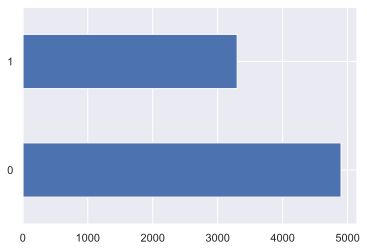

In [131]:
df["sentiment"].value_counts().plot.barh();

## Using the `nltk` library, we can easily check the most frequent words in tweets; Below we are looking at the 30 most frequent words (with more than 3 characters).

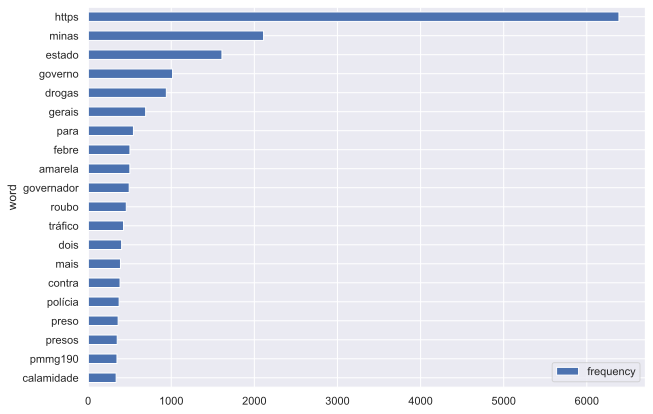

In [132]:
tweet_words = nltk.tokenize.word_tokenize(df["tweet"].drop_duplicates().str.lower().str.cat(sep=" ")) # separa em palavras
word_dist = fp.pipe(fp.keyfilter(lambda x: len(x) > 3, nltk.FreqDist(tweet_words)), # apenas palavras com mais de 3 caracteres
                    nltk.probability.FreqDist)

fig, ax = plt.subplots(figsize=(10, 7))

(pd.DataFrame(word_dist.most_common(20)[::-1],
              columns=['word', 'frequency'])
    .plot.barh(x="word", y="frequency", ax=ax));



## How does the tweets quantities varies daily ?

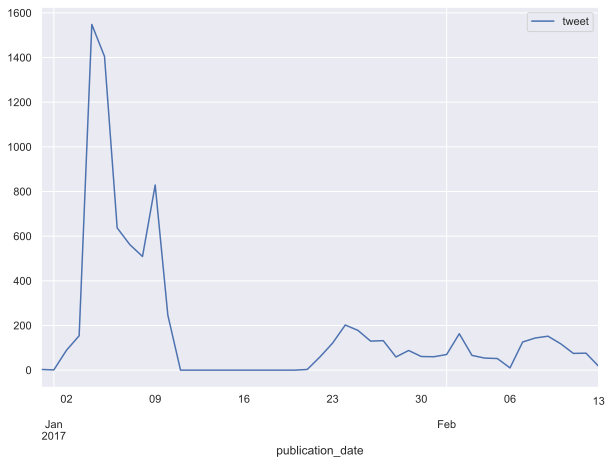

In [133]:
fig, ax = plt.subplots(figsize=(10, 7))
(df
     .groupby(pd.Grouper(key="publication_date", freq="D"))
     .count()
     .sort_values(by="publication_date")[["tweet"]]
     .plot(ax=ax));

## Which users posted the most tweets, and how many tweets did they post?

<AxesSubplot:ylabel='username'>

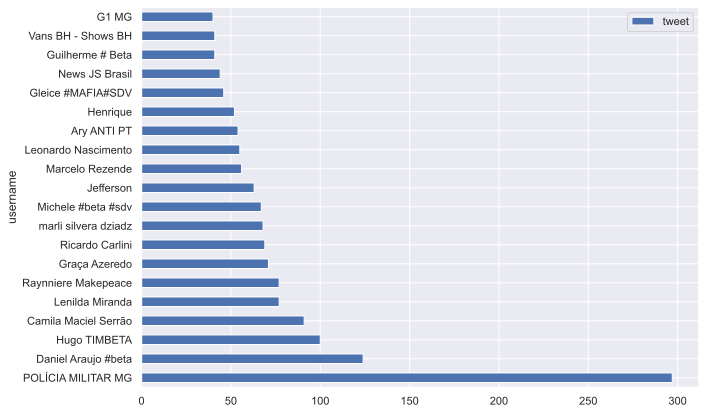

In [67]:
fig, ax = plt.subplots(figsize=(10, 7))

df_grouped = df.groupby("username").agg({"tweet": "count"})
df_sorted = df_grouped.sort_values(by="tweet", ascending=False)
df_top_25 = df_sorted.head(20)

df_top_25.plot.barh(ax=ax)

plt.show()

## tweets distribution

* As in many real-life datasets, here we see a clear problem with this dataset: The temporal distribution of tweet sentiments is quite different for the two classes. As of late January 2017, there are virtually no more examples of tweets classified as negative. This can greatly worsen the generalization of the model...

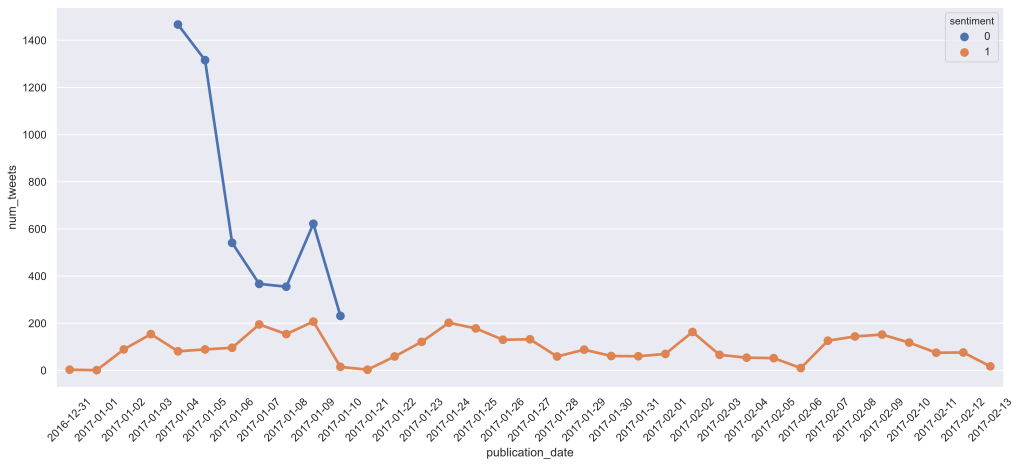

In [68]:
fig, ax = plt.subplots(figsize=(17, 7))
sns.pointplot(data=(df
                        .assign(publication_date=df["publication_date"].dt.strftime("%Y-%m-%d"))
                        .groupby(["publication_date", "sentiment"])["tweet"]
                        .count()
                        .reset_index() 
                        .rename(columns={"tweet": "num_tweets"})),
              x="publication_date",
              y="num_tweets",
              hue="sentiment",
              ax=ax)
plt.xticks(rotation=45);


## Histogram of the number of tweets and retweets per user

 - Most users in the dataset have 1-3 tweets. The amount of retweets is also asymmetric for few tweets. In this model we will not use the number of retweets, only the text of the tweet.

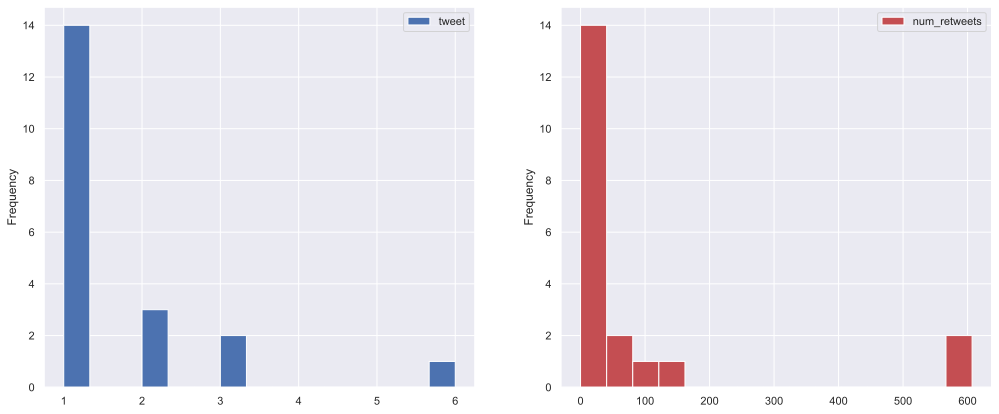

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))
(df
     .groupby("username")
     .agg({"tweet": "count"})
     .head(20).plot.hist(ax=ax[0], bins=15))
(df
     .groupby("username")
     .agg({"num_retweets": "sum"})
     .head(20).plot.hist(ax=ax[1], bins=15, color="r"));

## ECDF of the amount of tweets and retweets

* The ECDF of tweets gives us a lot more information about our data than a histogram. At first glance, we can see that practically 95% of the entire user base has less than 10 tweets and that there are outliers of users with something close to 300 tweets.



* The ECDF of the amount of retweets is a little different, although we also noticed that about 90% of the base has less than 125 retweets, and there are also outliers, which is to be expected.

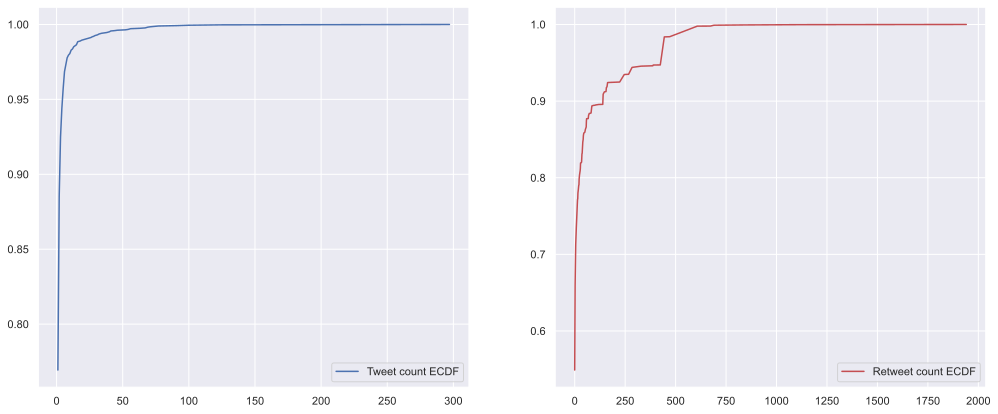

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

tweet_count = df.groupby("username").agg({"tweet": "count"})["tweet"].sort_values().values
retweet_count = df["num_retweets"].sort_values().values

tweet_count_ecdf = ECDF(tweet_count)
retweet_count_ecdf = ECDF(retweet_count)

ax[0].plot(tweet_count, tweet_count_ecdf(tweet_count), color="b")
ax[1].plot(retweet_count, retweet_count_ecdf(retweet_count), color="r")

ax[0].legend(labels=["Tweet count ECDF"], loc=4)
ax[0].get_legend().legendHandles[0].set_color("b")

ax[1].legend(labels=["Retweet count ECDF"], loc=4)
ax[1].get_legend().legendHandles[0].set_color("r")


plt.show()

### 2. train pipeline

### The  fklearn  library already has some pre-implemented learners. In this case, we will use nlp_logistic_classification_learner. This is a basic model for text classification that puts together a Tfidf followed by a logistic regression.

In [71]:
from fklearn.training.classification import nlp_logistic_classification_learner
from fklearn.training.pipeline import build_pipeline
from fklearn.training.utils import log_learner_time


def training_pipeline(text_cols, target_column, vectorizer_params, logistic_params):
    return log_learner_time(
        build_pipeline(
            nlp_logistic_classification_learner(
                text_feature_cols=text_cols,
                target=target_column,
                vectorizer_params=vectorizer_params,
                logistic_params=logistic_params
            )
        ), "tweet_sentiment_analysis")


**Tfidf and logistic regression parameters**

Let's change some parameters of `TfidfVectorizer`, and `LogisticRegression`

In [72]:
vectorizer_parameters = dict(decode_error="replace",
                             lowercase=True,
                             stop_words=nltk.corpus.stopwords.words("portuguese"),
                             ngram_range=(1, 3),
                             strip_accents=None)

logistic_regression_parameters = dict(random_state=42,
                                      n_jobs=-1,
                                      solver="lbfgs")

### 3. evaluation function

We will evaluate using the following metrics:
- AUC
- LogLoss
- Precision
- Recall

And in this case we will also evaluate the performance of the model over time. In this case, we are separating time into weeks,

In [134]:
from fklearn.validation.evaluators import auc_evaluator, logloss_evaluator, precision_evaluator, recall_evaluator, \
                                          combined_evaluators, temporal_split_evaluator

def tweet_eval(target_column, prediction_column, time_column):
    eval_args = dict(target_column=target_column,  prediction_column=prediction_column)
    basic_evaluator = combined_evaluators(evaluators=[
        auc_evaluator(**eval_args),
        logloss_evaluator(**eval_args),
        precision_evaluator(**eval_args),
        recall_evaluator(**eval_args)
    ])
    
    final_evaluator = combined_evaluators(evaluators=[
        basic_evaluator,
        temporal_split_evaluator(eval_fn=basic_evaluator, time_col=time_column, time_format="%Y-%U") # Weekly
    ])
    return final_evaluator


### 4. Separation of training and validation data

Let's make the separation between training and validation using `space_time_split_dataset`. The time column in this model is `publication_date`, and the "space" is `username`: The purpose of this evaluation in time and space is to ensure the robustness of the model for generalization.

In [74]:
dict(time_min=df["publication_date"].min(),
     time_max=df["publication_date"].max(),
     unique_users=df["username"].unique().shape)

{'time_min': Timestamp('2016-12-31 18:51:58+0000', tz='UTC'),
 'time_max': Timestamp('2017-02-13 11:03:33+0000', tz='UTC'),
 'unique_users': (3907,)}

In [75]:
from fklearn.preprocessing.splitting import space_time_split_dataset

train_set, intime_outspace_hdout, outime_inspace_hdout, outime_outspace_hdout = \
                                        space_time_split_dataset(df,
                                                 train_start_date="2016-12-31",
                                                 train_end_date="2017-01-10",
                                                 holdout_end_date="2017-02-13",
                                                 split_seed=42,
                                                 space_holdout_percentage=0.2,
                                                 space_column="username",
                                                 time_column="publication_date")

# (train_set.shape,
#  intime_outspace_hdout.shape, 
#  outime_inspace_hdout.shape,
#  outime_outspace_hdout.shape)

In [76]:
holdout_set = pd.concat((intime_outspace_hdout, outime_inspace_hdout, outime_outspace_hdout))

## 5. Putting it all together and building the model
Creating the training pipeline and evaluation function

In [77]:
train_fn = training_pipeline(text_cols=["tweet"], target_column="sentiment", 
                             vectorizer_params=vectorizer_parameters, logistic_params=
logistic_regression_parameters)

eval_fn = tweet_eval(target_column="sentiment",prediction_column="prediction", time_column="publication_date")

## training on  `train_set`

In [78]:
predict_function, training_scored, training_logs = train_fn(train_set)
training_evaluation = eval_fn(training_scored,)

In [108]:
training_evaluation

{'roc_auc_evaluator__sentiment': 0.9978999615865075,
 'logloss_evaluator__sentiment': 0.2922032299743378,
 'precision_evaluator__sentiment': 1.0,
 'recall_evaluator__sentiment': 0.22793296089385476,
 'split_evaluator__publication_date_2017-02': {'roc_auc_evaluator__sentiment': 0.9954625000000001,
  'logloss_evaluator__sentiment': 0.36870072131946274,
  'precision_evaluator__sentiment': 1.0,
  'recall_evaluator__sentiment': 0.24333333333333335},
 'split_evaluator__publication_date_2017-01': {'roc_auc_evaluator__sentiment': 0.9987620005976952,
  'logloss_evaluator__sentiment': 0.2670909811441244,
  'precision_evaluator__sentiment': 1.0,
  'recall_evaluator__sentiment': 0.22128378378378377},
 'split_evaluator__publication_date_2016-52': {'roc_auc_evaluator__sentiment': nan,
  'logloss_evaluator__sentiment': nan,
  'precision_evaluator__sentiment': 0.0,
  'recall_evaluator__sentiment': 0.0}}

## Evaluation on  `holdout_set`

In [79]:
holdout_scored = predict_function(holdout_set)
holdout_evaluation = eval_fn(holdout_scored)

In [80]:
predict_function(pd.DataFrame({"tweet": ["eu sou um tweet de Minas Gerais..."]}))

,tweet,prediction
0,eu sou um tweet de Minas Gerais...,0.19377


### 6. Model performance

Instead of manually looking at the logs (within the `training_evaluation` and `holdout_evaluation` dictionaries), we can use `fklearn`'s extract functions to facilitate the visualization of this data.

Below we create a `base_extractor` that will extract the 4 columns with the basic metrics we use (auc, logloss, precision, recall).

The result of the temporal evaluation we made will be available in the keys of the form `"split_evaluator__publication_date_"`. We then create a function that maps all the splits made and returns a `split_evaluator_extractor`. This function is called `create_year_week_extractor`.

In [118]:
from fklearn.metrics.pd_extractors import *
eval_auc_col =  "roc_auc_evaluator__sentiment"
eval_logloss_col = "logloss_evaluator__sentiment"
eval_precision_col =  "precision_evaluator__sentiment"
eval_recall_col = "recall_evaluator__sentiment"

base_extractor = combined_evaluator_extractor(base_extractors=[evaluator_extractor(evaluator_name=eval_auc_col),
                                                               evaluator_extractor(evaluator_name=eval_logloss_col),
                                                               evaluator_extractor(evaluator_name=eval_precision_col),
                                                               evaluator_extractor(evaluator_name=eval_recall_col)])


# Create a split evaluator based on the publication date available for a df_evaluation dataframe
def create_year_week_extractor(df_evaluation):
    year_week_splits = sorted((k.replace("split_evaluator__publication_date_", "") for k in df_evaluation.keys() if "publication_date" in k))
    return split_evaluator_extractor(split_col="publication_date", split_values=year_week_splits, base_extractor=base_extractor)

In [119]:
base_extractor(training_evaluation)

,roc_auc_evaluator__sentiment,logloss_evaluator__sentiment,precision_evaluator__sentiment,recall_evaluator__sentiment
0,0.9979,0.292203,1.0,0.227933


**Holdout**

In [121]:
holdout_evaluation.keys()

dict_keys(['roc_auc_evaluator__sentiment', 'logloss_evaluator__sentiment', 'precision_evaluator__sentiment', 'recall_evaluator__sentiment', 'split_evaluator__publication_date_2017-01', 'split_evaluator__publication_date_2017-02', 'split_evaluator__publication_date_2017-04', 'split_evaluator__publication_date_2017-05', 'split_evaluator__publication_date_2017-06', 'split_evaluator__publication_date_2017-07', 'split_evaluator__publication_date_2017-03'])

In [122]:
base_extractor(holdout_evaluation)

,roc_auc_evaluator__sentiment,logloss_evaluator__sentiment,precision_evaluator__sentiment,recall_evaluator__sentiment
0,0.963934,0.85768,1.0,0.052764


###  Metrics over time

Remember that earlier we saw that there were no more examples with `sentiment == 0` after the month of January. Here we can understand this, because the AUC has a NaN value after February 2017...

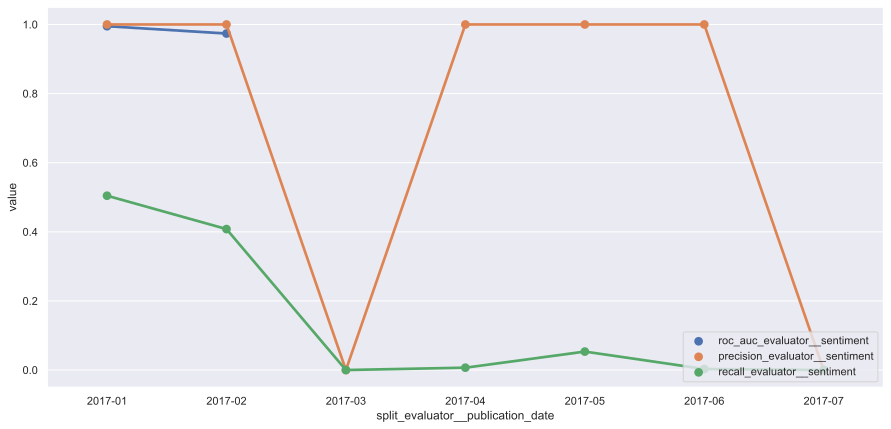

In [123]:
yweek_extractor_holdout = create_year_week_extractor(holdout_evaluation)

fig, ax = plt.subplots(figsize=(15, 7))

sns.pointplot(data=(yweek_extractor_holdout(holdout_evaluation)
                          .melt(id_vars=["split_evaluator__publication_date"],
                                value_vars=[eval_auc_col, eval_precision_col, eval_recall_col],
                                var_name="metric")),
              x="split_evaluator__publication_date",
              y="value",
              hue="metric",
              ax=ax)
ax.legend(loc=4);

**Curve *precision-recall***

The *precision* and *recall* values we saw above assume a `threshold = 0.5`, which is not always the best case. Usually in cases where the classes are unbalanced, it is recommended to look at the *precision-recall* curve, which allows to get more insights into the behavior of the model. We can use the dataframes returned by the `fklearn` training pipeline (in this case `training_scored` and `holdout_scored`) to visualize this curve, using the `precision_recall_curve` function.

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Precision-Recall Curve')

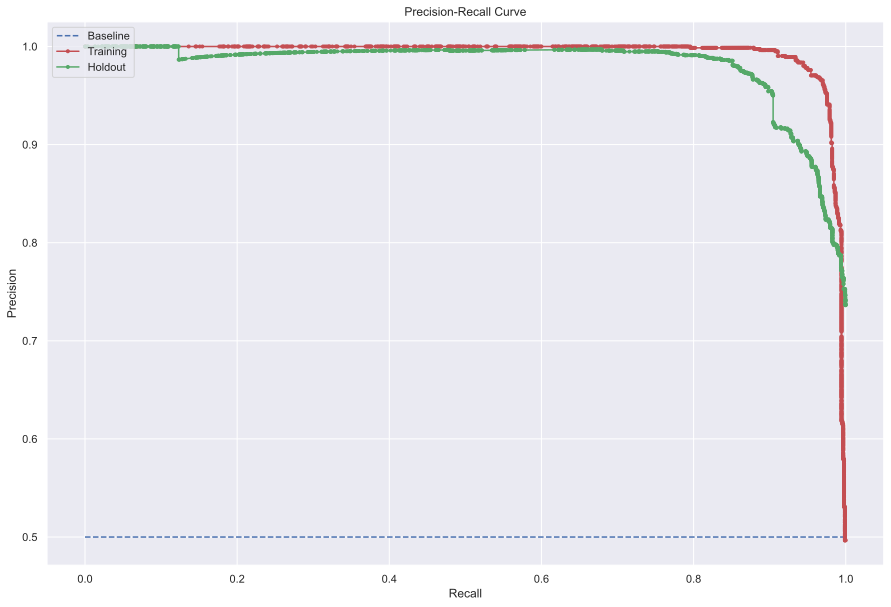

In [126]:
from sklearn.metrics import precision_recall_curve

precision_training, recall_training, _ = precision_recall_curve(training_scored["sentiment"], training_scored["prediction"])
precision_holdout, recall_holdout, _ = precision_recall_curve(holdout_scored["sentiment"], holdout_scored["prediction"])

# Plot curve
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot([0, 1], [0.5, 0.5], linestyle='--', color="b")
ax.plot(recall_training, precision_training, marker='.', color="r")
ax.plot(recall_holdout, precision_holdout, marker='.', color="g")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve")

ax.legend(labels=["Baseline", "Training", "Holdout"], loc=2)
ax.get_legend().legendHandles[0].set_color("b")
ax.get_legend().legendHandles[1].set_color("r")
ax.get_legend().legendHandles[2].set_color("g")